In [1]:
# Python imports
import sys, numpy as np
# Torch
import torch, torchvision, torch.nn as nn, torch.optim as optim
# Navigation MDP
import navigation_mdp as NvMDP
from navigation_mdp.plotting import *
from navigation_vis.Raster import Raster as NavGridView

# RL utils
import rl.planning as Plan
import rl.policy as Policy
from rl.model import RewardLinear
# Utils
from utils.utils import *
# Matplotlib
from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

## Gridworld 5x7

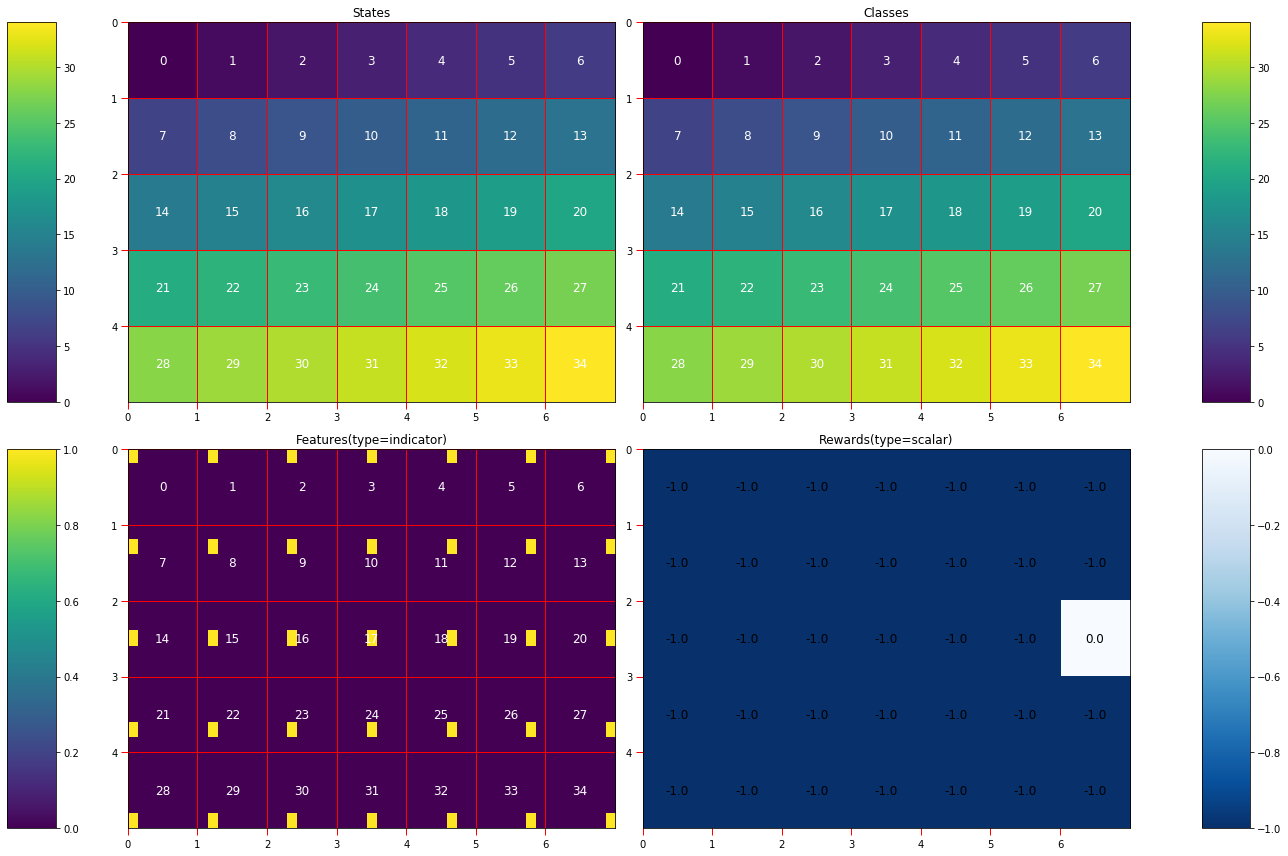

In [2]:
np.random.seed(5)
# Specify state space
S = NvMDP.state.DiscreteStateSpace(5, 7)
goal = (2,6)
# Attach classes
class_ids = NvMDP.class_.XYClassDistribution(np.arange(5 * 7).reshape(5, 7))().flatten()
S.attach_classes(class_ids)
# Attach features
S.attach_feature_spec(NvMDP.features.FeatureClassIndicatorOneHot(key="indicator"))
# Attach rewards
S.attach_reward_spec(NvMDP.reward.RewardStateScalar(loc_to_reward_dict={goal: 0.}, 
                                                    class_id_to_reward_dict={}, 
                                                    default=-1, 
                                                    key="scalar"))
R = S.rewards(key="scalar")
# Specify dynamics
T = NvMDP.dynamics.XYDynamics(S, slip_prob=0.)
# Set goal
# S.set_terminal_status_by_loc([goal])
plot_irl_world(S, [], r_key="scalar", phi_key="indicator", v_range=[None, None, None, (0,-1)])

RewardLinear(
  (fc_reward): Linear(in_features=35, out_features=1, bias=False)
  (sigmoid): Sigmoid()
  (reward_activation): Sigmoid()
)


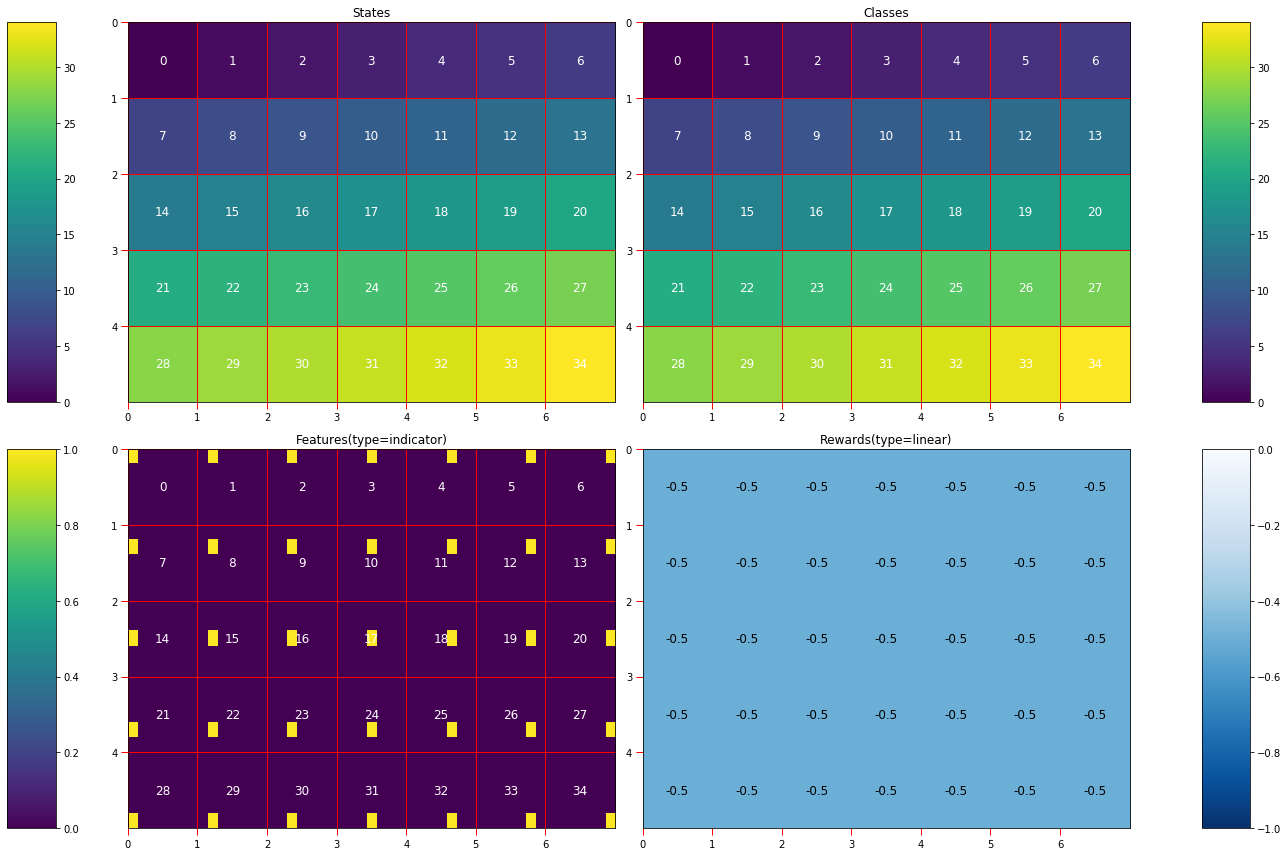

In [3]:
PHI = torch.FloatTensor(S.features(key="indicator"))

r_model_linear = RewardLinear(PHI[0].numpy().shape[0], lr=0.2, weight_decay=0.)
r_model_linear.init_const(0)
print(r_model_linear)
preprocess_fn = lambda x: torch.FloatTensor(x)
postprocess_fn = lambda x: x.squeeze()

S.attach_reward_spec(
    NvMDP.reward.RewardStateFeatureModel(
        r_model = r_model_linear,
        preprocess_fn=preprocess_fn,
        key="linear", feature_key="indicator")
)

plot_irl_world(S, [], r_key="linear", phi_key="indicator", v_range=[None, None, None, (0,-1)])

In [4]:
# # T.ACTIONS: ['U', 'D', 'L', 'R']
# Sk = S.at_loc((2,2))
# Ak = "U"
boltzmann_temp = 0.05
goal = S.at_loc((2,6))
log_likelihoods_history = []
s_lst_lst = [[(2,0), (2,1), (1,1), (1,2), (1,3), (1,4), (1,5), (2,5), (2,6)],
            [(2,0), (2,1), (3,1), (3,2), (3,3), (3,4), (3,5), (2,5), (2,6)]]
a_lst_lst = [T.loc_lst_to_a_lst(s_lst) for s_lst in s_lst_lst]

for _iter in range(100):
    _iter_start_time = time.time()
    r_model_linear.zero_grad()
    
    VI = Plan.ValueIteration(S, r_model_linear(PHI), T, verbose=True, log_pi=False, gamma=0.95, goal=goal)
    Pi, V, Q, iterno, v_delta_max, _ = VI.run(100, lambda q: Policy.Boltzmann(q, boltzmann_temp=boltzmann_temp), 
                                           verbose=True, debug=False, eps=1e-4, ret_vals=True)
    values = V.detach().numpy().round(2)
    loss = 0
    for k in range(len(s_lst_lst)):
        for i in range(len(s_lst_lst[k])-1):
            loss += -torch.log(VI.Pi[VI.get_tbl_idxs(S.at_loc(s_lst_lst[k][i]), a_lst_lst[k][i])])
#     for i in range(6):
#         loss += -torch.log(Pi[VI.get_tbl_idxs(S.at_loc((2,0+i)), "R")])
#         print(Pi[VI.get_tbl_idxs(S.at_loc((2,1+i)), "R")], loss)

    ll = np.exp(-loss.detach().item())
    log_likelihoods_history.append(ll)
    
    print("\n>>> Iter: {:04d} ({:03.3f}s): loss = {:09.6f}, likelihood = {:02.4f}\n\n".format(
                    _iter, time.time()-_iter_start_time, loss, ll))
    loss.backward()
    r_model_linear.step()
    # print(torch.sum(r_model_linear.fc1.weight.grad))
#     print(torch.sum(r_model_linear.w.weight.grad))

Setting goal as terminal state!
Learning values [  0 ] Converged @ 10.
Reasoning [  10 19 ] Done (10 iters).

>>> Iter: 0000 (0.307s): loss = 37.110191, likelihood = 0.0000


Learning values [  0 ] Converged @ 11.
Reasoning [  11 20 ] Done (10 iters).

>>> Iter: 0001 (0.321s): loss = 16.945639, likelihood = 0.0000


Learning values [  0 ] Converged @ 11.
Reasoning [  11 20 ] Done (10 iters).

>>> Iter: 0002 (0.302s): loss = 06.913630, likelihood = 0.0010


Learning values [  0 ] Converged @ 11.
Reasoning [  11 20 ] Done (10 iters).

>>> Iter: 0003 (0.302s): loss = 03.699116, likelihood = 0.0247


Learning values [  0 ] Converged @ 11.
Reasoning [  11 20 ] Done (10 iters).

>>> Iter: 0004 (0.299s): loss = 02.138701, likelihood = 0.1178


Learning values [  0 ] Converged @ 12.
Reasoning [  12 21 ] Done (10 iters).

>>> Iter: 0005 (0.315s): loss = 01.609090, likelihood = 0.2001


Learning values [  0 ] Converged @ 12.
Reasoning [  12 21 ] Done (10 iters).

>>> Iter: 0006 (0.314s): loss = 

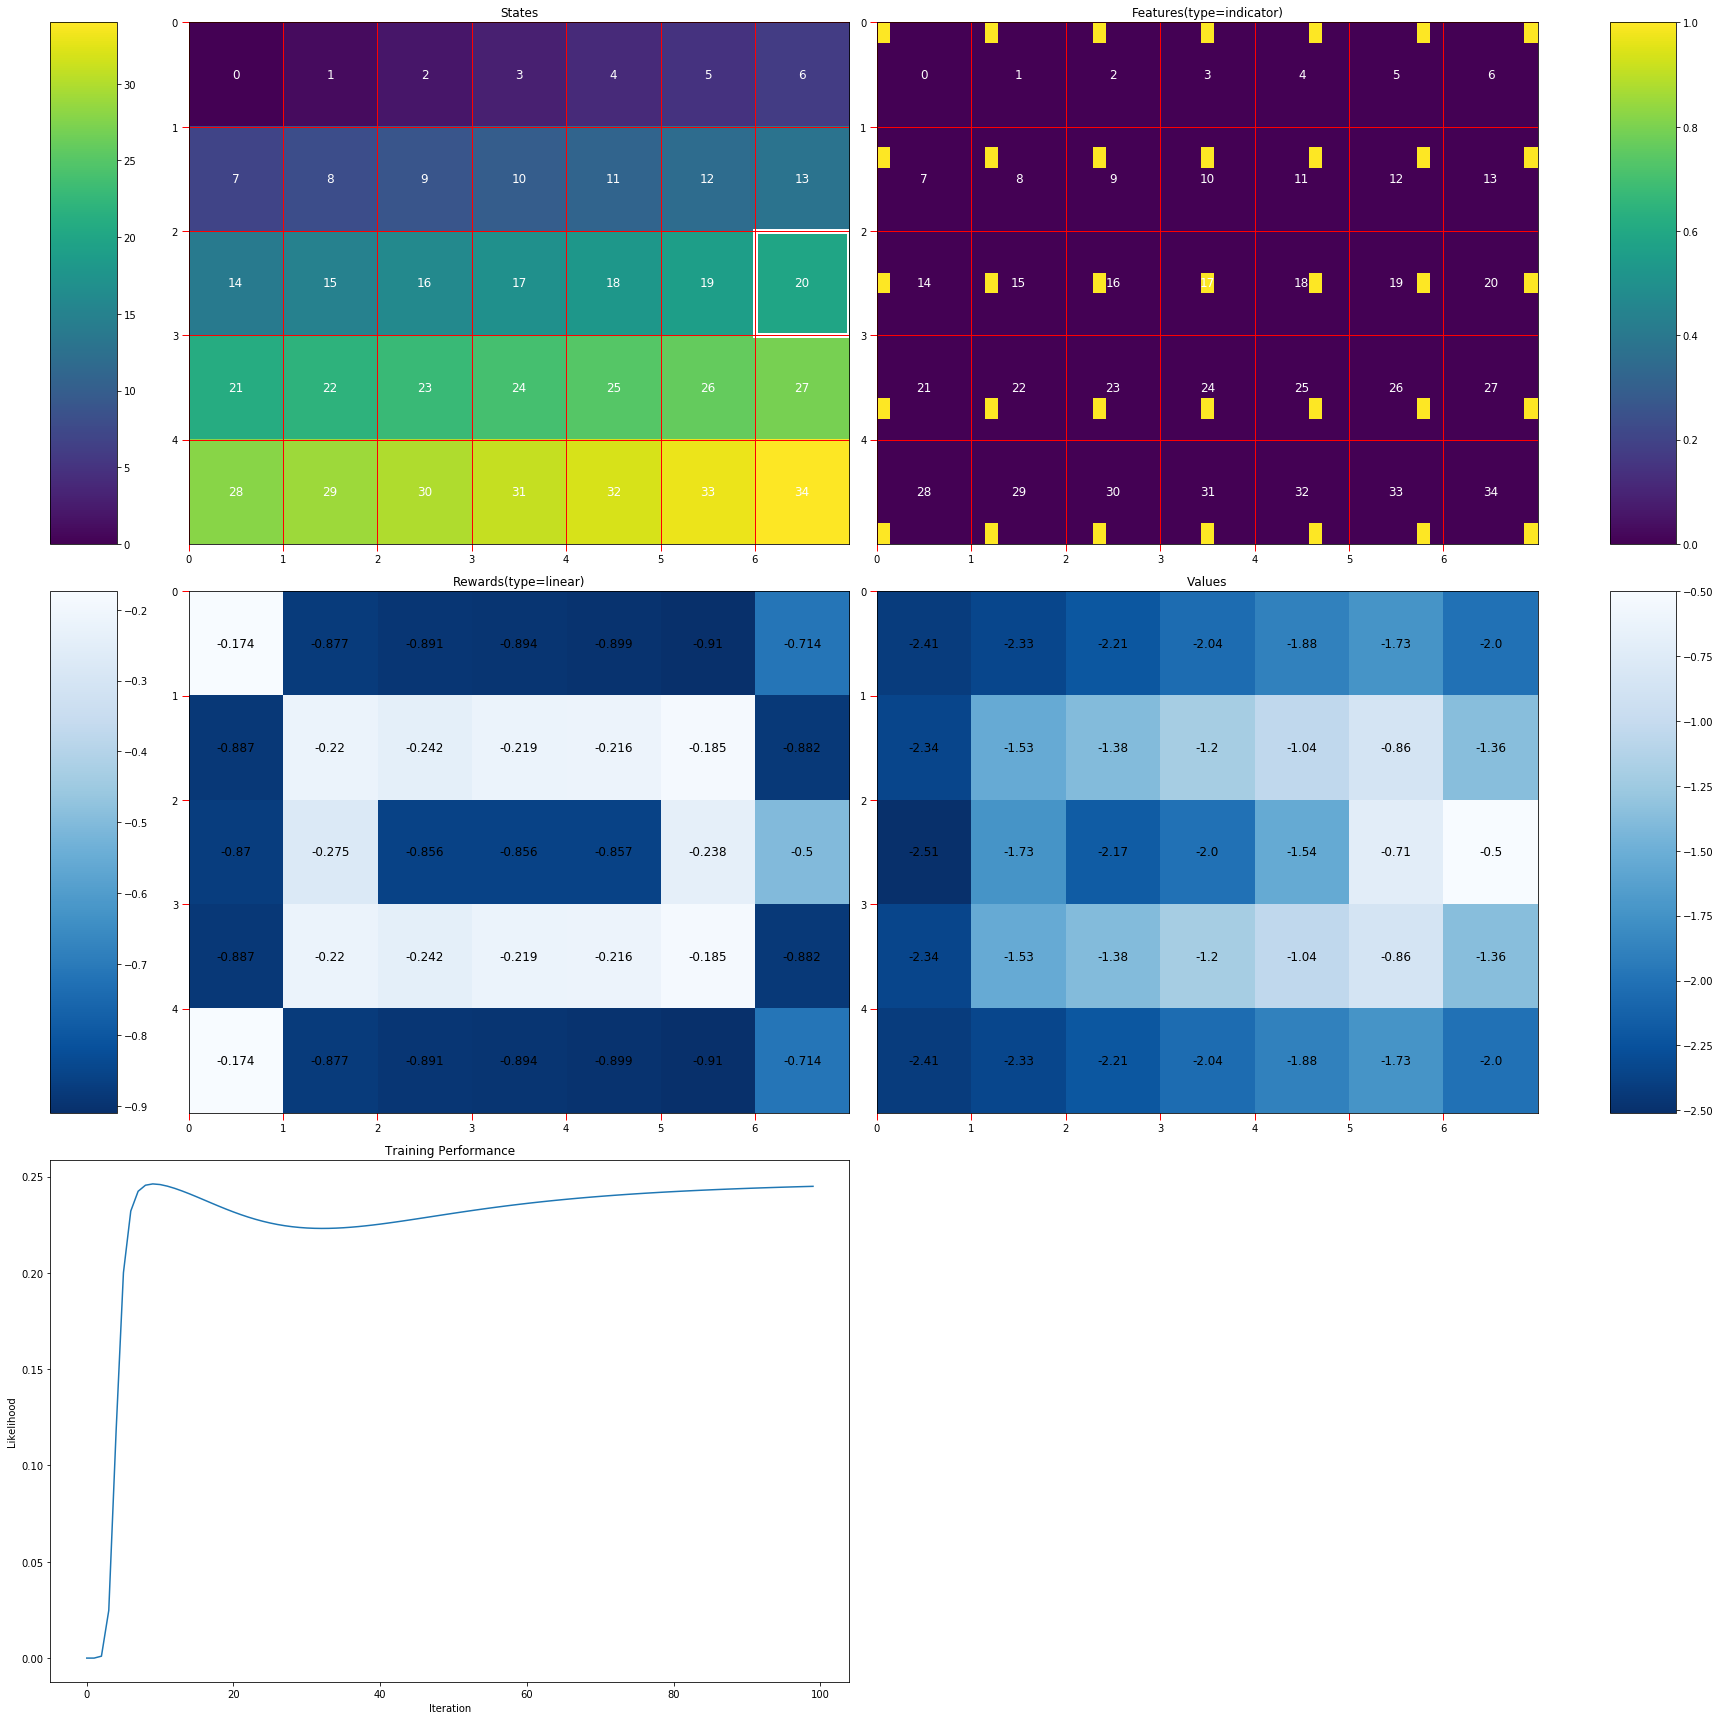

In [5]:
plot_irl_results(S, [], VI.V.detach().numpy().round(2),
                 log_likelihoods_history, r_key="linear", phi_key="indicator")
plt.savefig("./figures/mlirl_gw_5x7_one_hot__traj_2_turns")